## Deep Hedging
#### Notebook for computing utility values without any hedging. Helps comparing different lambda values. 


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
print(p)
dhn = "/deephedging"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

C:\Users\hansb\iCloudDrive\Python3\deephedging\notebooks


Deep Hedging AI says hello ... Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


## Computing Utility Values for a Payoff

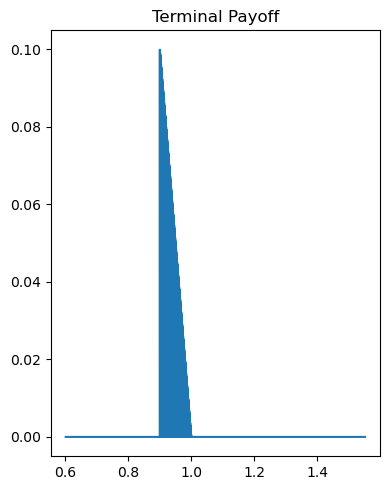

Utility computed using analytic: 0.0065217
Utility computed using TF (standalone): 0.00652218
Utility computed using TensorFlow: 0.00652197 (with full batch)


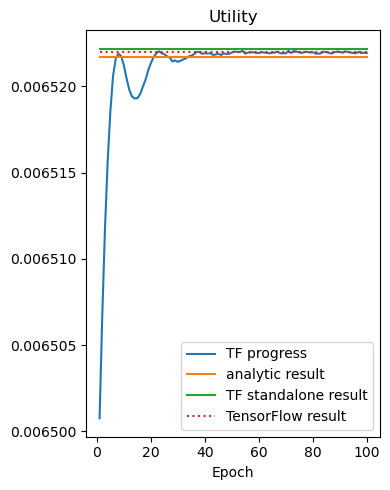

In [2]:
%matplotlib inline
print("Deep Hedging AI says hello ... ", end='')

import importlib as imp
import deephedging.objectives as _
imp.reload(_)

from cdxbasics.config import Config
from deephedging.trainer import train, train_utillity
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
from deephedging.objectives import MonetaryUtility, oce_utility
import numpy as np

from cdxbasics.dynaplot import figure, colors_tableau
from IPython.display import display, Markdown

# create world
# ------------

def barrier_option( spots ):
    """ KO 
    
        Parameters
        ----------
            spots : spots of the equity[None,nSteps]
            
        Returns
        -------
            Payoff [None]
    """
    pcent      = 0.1
    put_strike = 1.0
    lower_KO   = 1.-pcent
    upper_KO   = 1.+pcent
    terminal   = np.maximum( put_strike - spots[:,-1], 0. )  # put
    lower      = np.where( np.min( spots, axis=1 ) >= lower_KO, 1., 0. )
    upper      = np.where( np.max( spots, axis=1 ) <= upper_KO, 1., 0. )
    return terminal*lower*upper

wconfig = Config()
wconfig.samples = 10000
wconfig.steps = 20
wconfig.black_scholes = True
wconfig.payoff = barrier_option
world  = SimpleWorld_Spot_ATM( wconfig )
val_world  = world.clone(samples=world.nSamples//10)

display(Markdown("## Computing Utility Values for a Payoff"))

fig = figure()
ax  = fig.add_subplot()
ax.set_title("Terminal Payoff")
spotsT = world.details.spot_all[:,-1]
payoff = world.data.market.payoff
ixs    = np.argsort(spotsT)
spotsT = spotsT[ixs]
payoff = payoff[ixs]
ax.plot( spotsT,payoff )
fig.render()
fig.close()

uconfig = Config()
uconfig.utility = "exp"
uconfig.lmbda = 1.

utility = MonetaryUtility( uconfig )

# compute utility with minimize_scalar
# This will only work for utilities which are not state-dependent

u1 = oce_utility( uconfig("utility"), uconfig("lmbda"), world.tf_data['market']['payoff'], sample_weights=world.sample_weights, method=None )
print( ("Utility computed using analytic: %g" % u1)  if not u1 is None else "No analytic solution")
u2 = oce_utility( uconfig("utility"), uconfig("lmbda"), world.tf_data['market']['payoff'], sample_weights=world.sample_weights, method="minscalar" )
print("Utility computed using TF (standalone): %g" % u2) 

# compute utility with tensorflow
# this should work for all utillities, but is much slower

tconfig = Config()
tconfig.train.optimizer.name = "adam"
tconfig.train.batch_size = world.nSamples # full sample size
tconfig.train.epochs = 100
tconfig.train.tf_verbose = 0

u, u0, info = train_utillity( utility, world, config=tconfig )
print("Utility computed using TensorFlow: %g (with full batch)" % u) 

fig = figure()
ax = fig.add_subplot()
ax.set_title("Utility")
h  = - np.array( info.history['loss'] )
l  = len(h)
x  = np.linspace(1,l,l,endpoint=True)
ax.set_xlabel("Epoch")
ax.plot( x, h, label="TF progress")
if not u1 is None:ax.plot( x, x*0. + u1, label="analytic result")
ax.plot( x, x*0. + u2, label="TF standalone result")
ax.plot( x, x*0. + u , ":", label="TensorFlow result")
ax.legend()
fig.close()

## Computing Different Utility Values

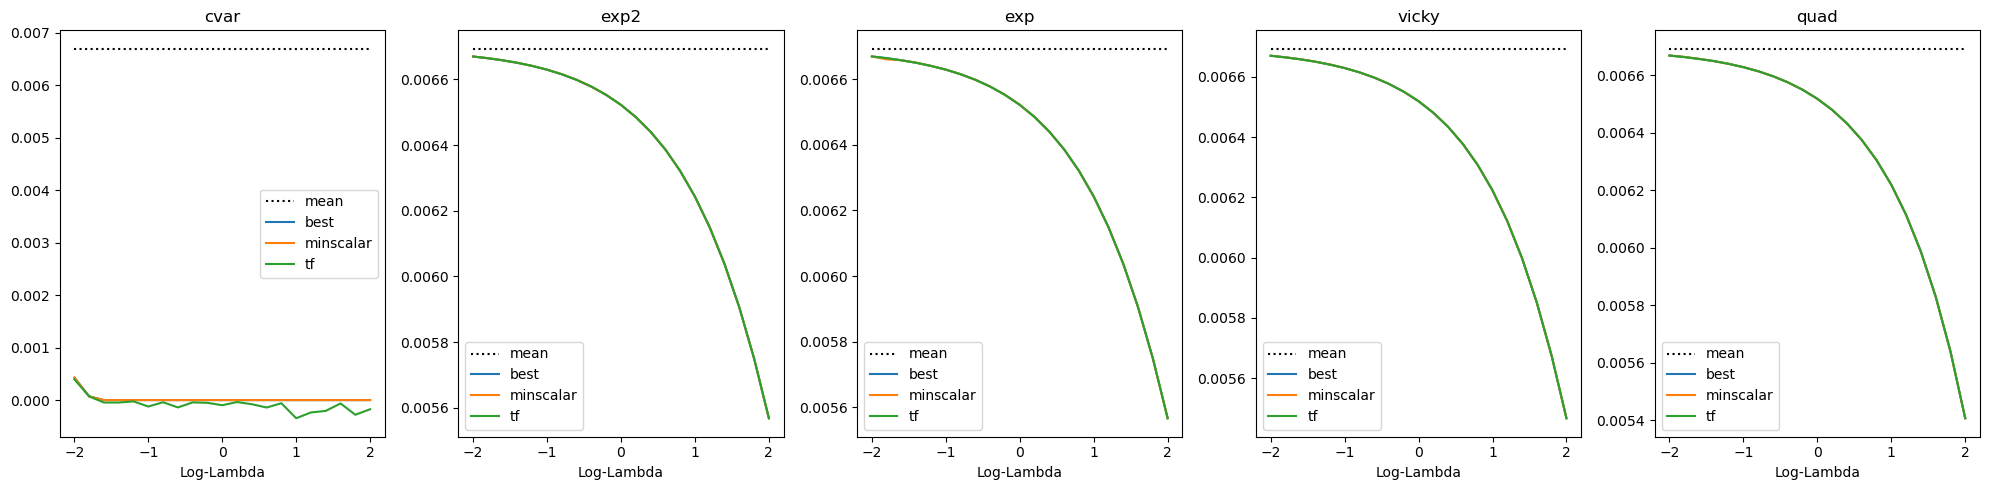

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:59<00:00, 47.93s/it]


In [3]:
from tqdm import tqdm
from scipy.optimize import minimize_scalar, minimize
import tensorflow as tf
from deephedging.base import tfCast, dh_dtype, _log
from deephedging.objectives import tf_utility, oce_utility
from cdxbasics.prettydict import PrettyOrderedDict as pdct

%matplotlib inline

display(Markdown("## Computing Different Utility Values"))

# create monetary utility
# ------------------------

utilities = ['cvar', 'exp2', 'exp', 'vicky', 'quad' ]
lambdas  = np.exp(np.linspace( -2.,2., 21, endpoint=True) )

fig = figure()
axs = dict()
for util in utilities:
    ax  = fig.add_subplot()
    ax.set_title(util)
    ax.set_xlabel("Log-Lambda")
    axs[util] = ax
fig.render()

mean   = np.sum( world.tf_data['market']['payoff'] * world.sample_weights )
payoff = world.data['market']['payoff']

for util in tqdm(utilities):
    results = pdct()
    results.best       = []
    results.minscalar  = []
    results.tf         = []
    ax = axs[util]

    for lmbda in tqdm(lambdas):
        uconfig = Config()
        uconfig.utility = util
        uconfig.lmbda = lmbda

        utility = MonetaryUtility( uconfig )

        u = oce_utility(  util, lmbda, X=payoff, method=None)
        if not u is None: results.best.append( u )
        u = oce_utility(  util, lmbda, X=payoff, method='minscalar')
        if not u is None: results.minscalar.append( u )
        u = oce_utility(  util, lmbda, X=payoff, method='tf')
        if not u is None: results.tf.append( u )
        
    ax.plot( np.log(lambdas), lambdas*0.+mean, ":", label="mean", color="black" )
    colors = colors_tableau()
    for k in results:
        color = next(colors)
        r     = results[k]
        if len(r) == 0:
            continue
        ax.plot( np.log(lambdas), r, label=k, color=color )
    ax.legend()
    fig.render()

fig.render()
fig.close()